$\LARGE{\textbf{Beyond the Two-Level System}}$

# Setup

In [111]:
## general qiskit imports

import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
from qiskit import IBMQ
import numpy as np
from qiskit import pulse
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import schedule
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [112]:
## save IBMQ account token

IBMQ.save_account('109f33eab1cac8f7fb13d4132013ccb6409a348c9b3fde61e13fdf41730a7949e314860eb3f9d9a62819080f6dd0af11a16d7632551e2e96e3d7a3a03e309b39')

configrc.store_credentials:WARNING:2022-12-03 17:02:29,361: Credentials already present. Set overwrite=True to overwrite.


In [113]:
## load IBMQ account and set the appropriate backend

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

ibmqfactory.load_account:WARNING:2022-12-03 17:02:29,512: Credentials are already in use. The existing account in the session will be replaced.


In [114]:
## verify that the backend supports Pulse features by checking the backend configuration

backend_config = backend.configuration()

In [115]:
##  find the sampling time for the backend pulses within the backend configuration

dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [116]:
## use granurality to determine the length of the pulse

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

In [117]:
## find least common multiple

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

Least common multiple of acquire_alignment and pulse_alignment: 16


In [118]:
## access estimates for qubit frequencies and default programs to enact basic quantum operators

backend_defaults = backend.defaults()

# Task 1

To begin, you first need to calibrate the qubit. Although the parameters of the qubit you
choose to work with is available on the IBM website, the numbers might vary slightly overtime, since the
systems go over constant calibrations within IBM. Therefore it is best to compute the parameters yourself
to get the most precise numbers for your experiment. Find the |0⟩ → |1⟩ qubit frequency using a frequency
sweep. Then calibrate the π pulse using a Rabi experiment. A tutorial for how to do the calibration is
shown [here](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html).

## Find the frequency of the |0⟩ → |1⟩ transition

In [119]:
## define frequency range for sweep in search of the qubit, restricting to a window of 40 MHz around the estimated qubit frequency

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.9622912380562285 GHz.
The sweep will go from 4.942291238056229 GHz to 4.982291238056229 GHz in steps of 1.0 MHz.


In [120]:
## define helper functions for pulse flow

# drive pulse of a frequency
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

# determine the length of the pulse
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

# adjust the length of the delay
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [121]:
## create a pulse schedule

# Drive pulse parameters
drive_sigma_sec = 0.015 * us # actual width of the gaussian pulse
drive_duration_sec = drive_sigma_sec * 8 # truncating parameter, as gaussians don't have a natural finite length
drive_amp = 0.05

# Create the base schedule, start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [122]:
## create sweep

sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

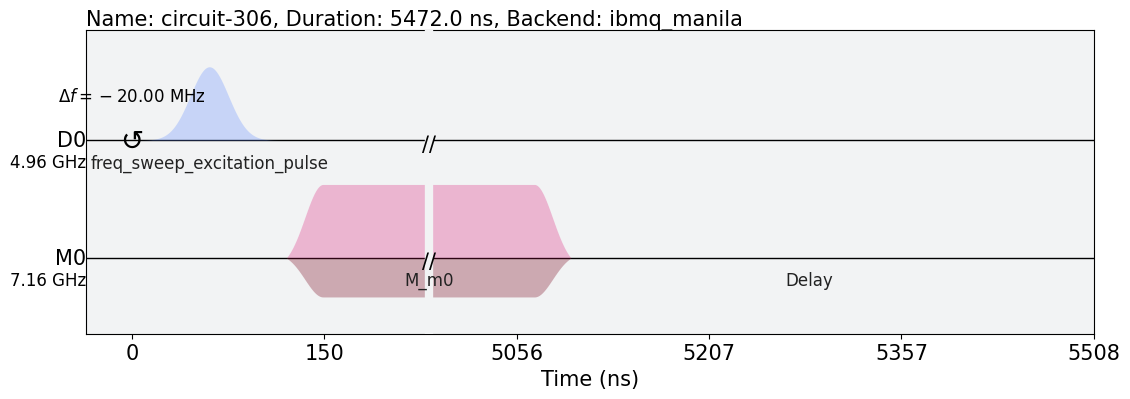

In [123]:
## draw sweep schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

In [124]:
## run assembled program on backend

num_shots_per_frequency = 1024

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [125]:
## monitor job status

job_monitor(job)

Job Status: job has successfully run


In [126]:
## retrieve job results

frequency_sweep_results = job.result(timeout=120)

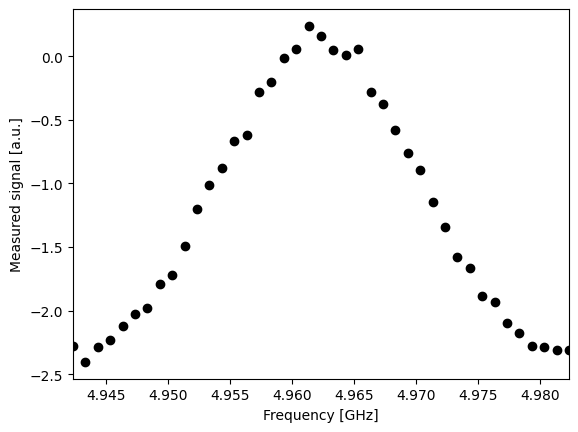

In [127]:
## plot job results

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

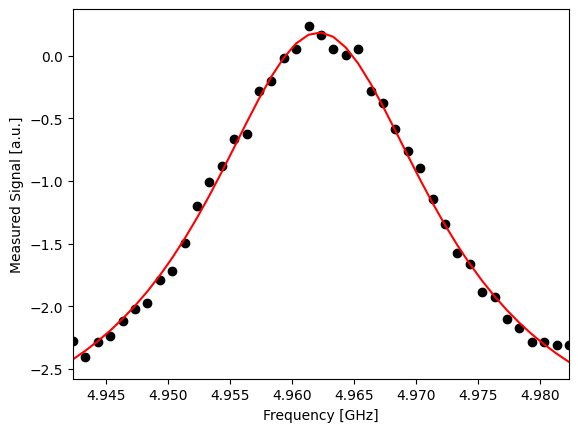

In [146]:
## fit values to a curve

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial parameters for curve_fit
                                )

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [147]:
# derive qubit frequency using peak

A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"Updated qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

Updated qubit frequency estimate from 4.96229 GHz to 4.96213 GHz.


## Calibrate the $\pi$ pulse using a Rabi experiment

In [130]:
## Set Rabi experiment parameters

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [131]:
## Build Rabi experiments

# A drive pulse at the qubit frequency, followed by a measurement, vary the drive amplitude each time
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [132]:
## create Rabi

rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

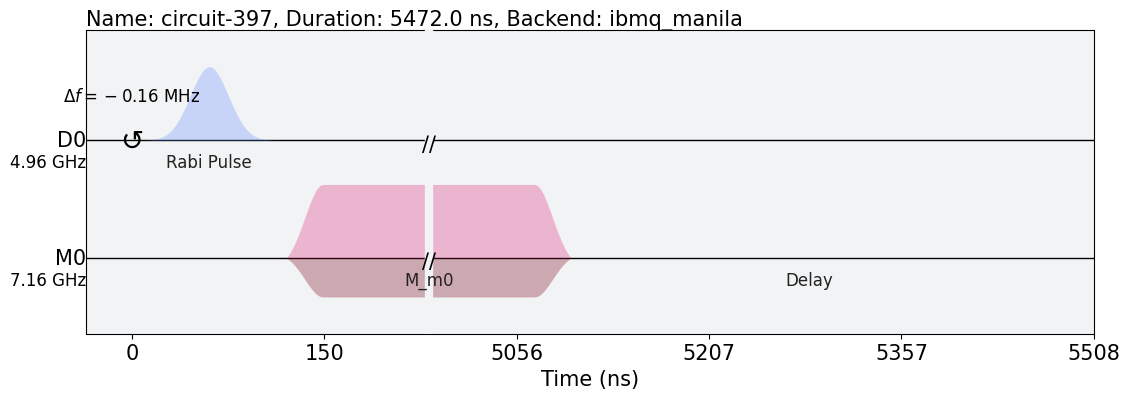

In [133]:
## draw Rabi schedule

rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [134]:
## run assembled program on backend

num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

In [135]:
## monitor job status

job_monitor(job)

Job Status: job has successfully run


In [136]:
## retrieve job results

rabi_results = job.result(timeout=120)

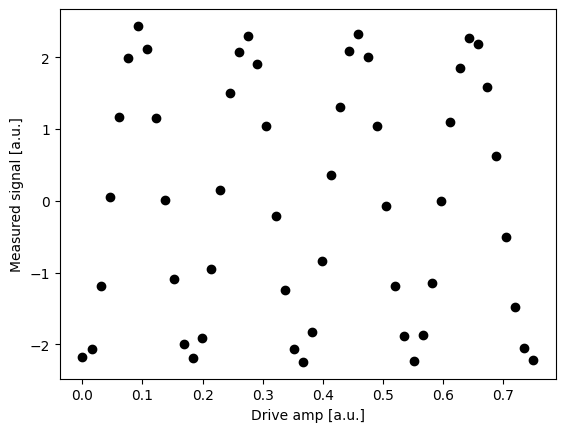

In [140]:
## plot job results

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

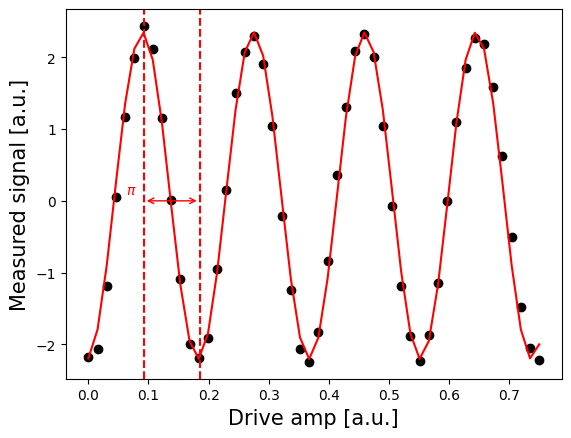

In [154]:
## fit values to a curve

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [-2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [155]:
# derive qubit frequency using period

pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.09250723331612425


In [159]:
## create pi pulse

with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

# Task 2

## Set qubit state to |1⟩ using a |0⟩ → |1⟩ transition

In [162]:
## create excited state schedule

with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)

In [164]:
## create excited state calibration

qc_exc = QuantumCircuit(1, 1)
qc_exc.x(0)
qc_exc.measure(0, 0)

qc_exc.add_calibration("x", (0,), exc_schedule, [])

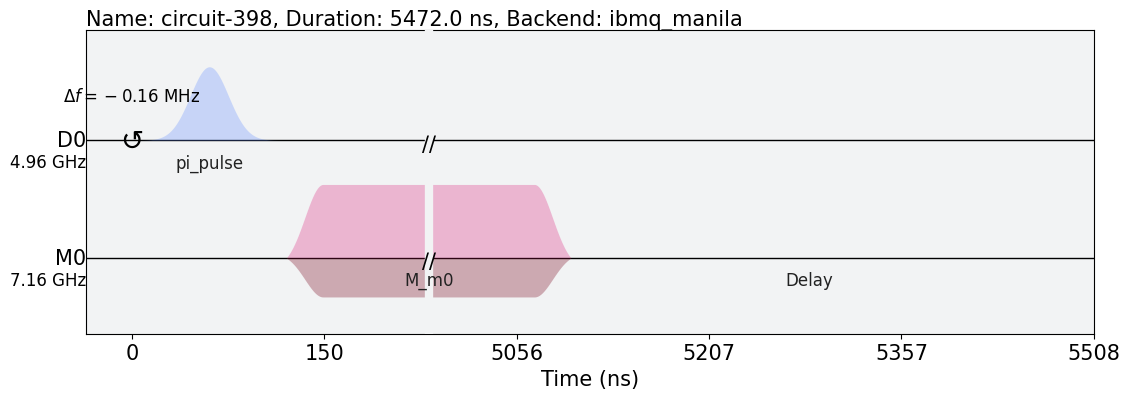

In [165]:
## draw excited state

exec_schedule = schedule(qc_exc, backend)
exec_schedule.draw(backend=backend)

In [182]:
# run assembled program on backend
num_shots = 1024

job = backend.run(qc_exc, 
                  meas_level=0, 
                  meas_return='single', 
                  shots=num_shots)

In [183]:
## monitor job status

job_monitor(job)

Job Status: job is queued (1)

In [184]:
## retrieve job results

exc_results = job.result(timeout=120)

In [187]:
## verify that most qubits are excited

exc_results.get_counts()

Result(backend_name='ibmq_manila', backend_version='1.1.0', qobj_id='e847b15c-1385-4d24-ab58-13e586c96354', job_id='638bd494b29f0b2bb4275741', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 23, '0x1': 1001}), header=QobjExperimentHeader(qubit_labels=[['q', 0]], n_qubits=1, qreg_sizes=[['q', 1]], clbit_labels=[['c', 0]], memory_slots=1, creg_sizes=[['c', 1]], name='circuit-398', global_phase=0.0, metadata={}), status=done)], date=2022-12-03 18:00:16-05:00, status=Successful completion, header=QobjHeader(backend_name='ibmq_manila', backend_version='1.1.0'), execution_id='3e2db3de-735e-11ed-a2be-bc97e15b08d0', time_taken=3.7861826419830322, error=None, client_version={'qiskit': '0.39.2'})


{'0': 23, '1': 1001}

## Find the frequency of the |1⟩ → |2⟩ transition

## Calculate anharmonicity

## Calibrate the π pulse using a Rabi experiment

## Part 3

In [160]:
## create ground state
qc_gnd = QuantumCircuit(1, 1)
qc_gnd.measure(0, 0)

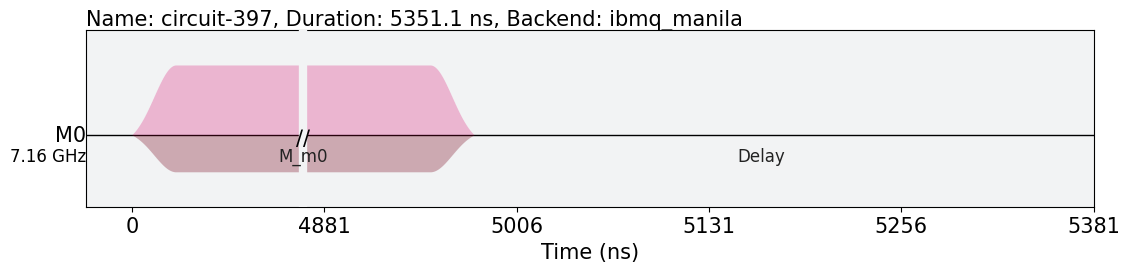

In [161]:
## draw ground state

gnd_schedule = schedule(qc_gnd, backend)
gnd_schedule.draw(backend=backend)

In [ ]:
## create excited state schedule

with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)

In [ ]:
## create excited state calibration

qc_exc = QuantumCircuit(1, 1)
qc_exc.x(0)
qc_exc.measure(0, 0)

qc_exc.add_calibration("x", (0,), exc_schedule, [])

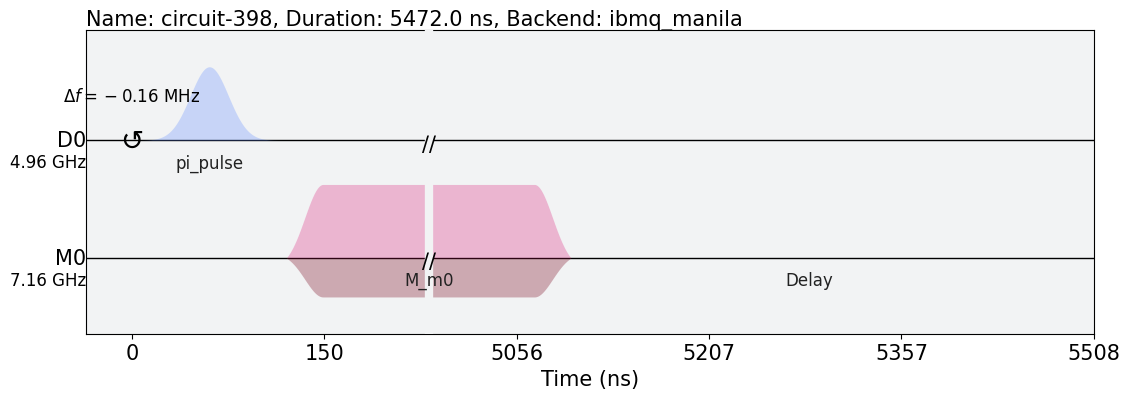

In [ ]:
## draw excited state

exec_schedule = schedule(qc_exc, backend)
exec_schedule.draw(backend=backend)

In [ ]:
# run assembled program on backend

num_shots = 1024

job = backend.run([qc_gnd, qc_exc], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

In [ ]:
## monitor job status

job_monitor(job)

In [ ]:
## retrieve job results

gnd_exc_results = job.result(timeout=120)

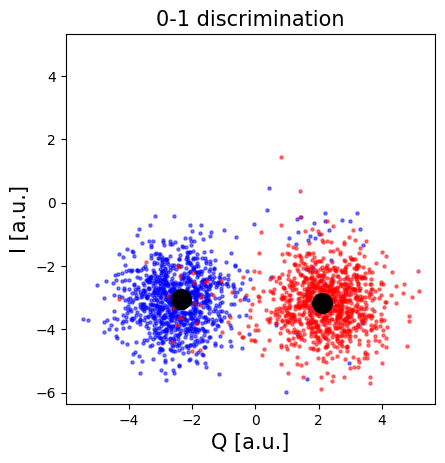

In [181]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure()

# Plot all the results
# All results from the ground state are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the excited state are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()